##__Problem:__

A supermarket company has a new internal policy to not discriminate salaries according to the location of their employees. They gathered the data from all of their employees and want you to verify if they are already following the new policy.

**Solution:**

The target variable in this problem is the salary, and the main objective is to determine if the location has a significant effect on the salary. Hence, a linear regression model can be adjusted to the data so I can check if the coefficients associated to the location variable are significant.

First, I will perform an Exploratory Data Analysis in order to see how the salary depends on the different variables, not only on the location. Depending on what I obtain from this EDA, I will be able to see if some feature engineering is necessary. Since the dataset contains some categorical variables, I will need to one-hot encode them before feeding them into the model.

Then I will adjust the linear regression model and do my analysis from this. Since the objective of this model will not be to predict, but to explain the relationships among variables, then a train-test split will not be necessary and I will use the whole dataset to adjust the model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import statsmodels.api as sm

In [3]:
# load the dataset
df = pd.read_excel('/content/drive/MyDrive/Employees_DataBase.xlsx')
print(df.shape)

# check for null values
print(df.isnull().sum())

df.head()

(80, 7)
ID                0
EDUCAÇÃO          0
CARGO             0
LOCAL             0
IDADE             0
TEMPOCASA         0
SALARIO_MENSAL    0
dtype: int64


,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
0,1,SECUNDÁRIO,GERENTE,INTERIOR,30,1,4279.5
1,2,SUPERIOR,AUXILIAR,INTERIOR,32,4,4575.4
2,3,SECUNDÁRIO,AUXILIAR,CAPITAL,33,2,4735.6
3,4,SUPERIOR,GERENTE,INTERIOR,34,3,4863.1
4,5,SECUNDÁRIO,GERENTE,INTERIOR,36,1,5355.8


In [4]:
# check the categories in the categorical columns
for col in df.columns[1:4]:
    print('{}: {}'.format(col, df[col].unique()))

EDUCAÇÃO: ['SECUNDÁRIO' 'SUPERIOR']
CARGO: ['GERENTE' 'AUXILIAR' 'DIRETOR']
LOCAL: ['INTERIOR' 'CAPITAL']


Salaries usually depend on the level of education ('EDUCAÇÃO'), and the hierarchy of the job title ('CARGO'). But according to the new policy of the company, salaries should not depend on 'LOCAL'. So let's plot some relationships to check it:

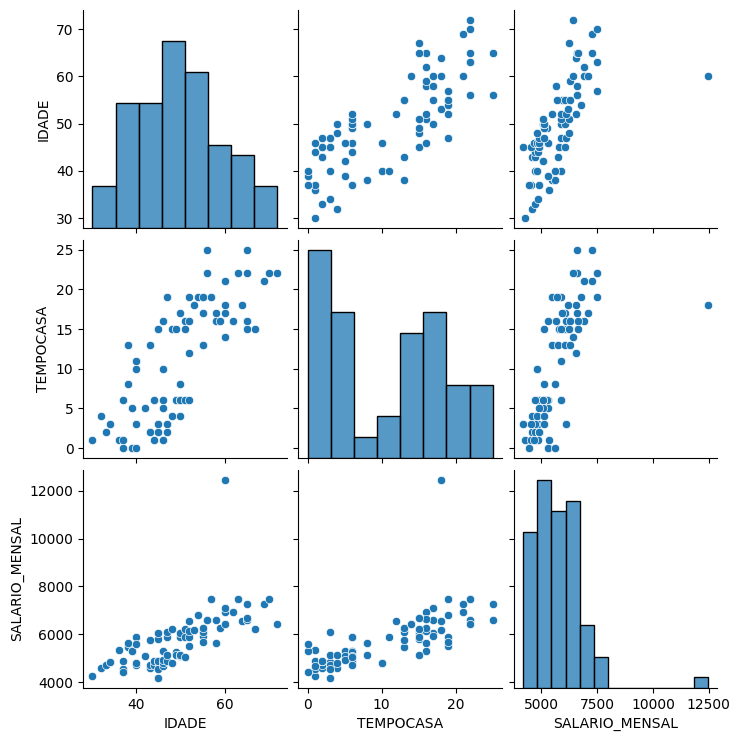

In [5]:
# take a look at the numerical columns
sns.pairplot(df.drop('ID', axis=1))

In [6]:
# who is the outlier?
df[df['SALARIO_MENSAL'] == df['SALARIO_MENSAL'].max()]

,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
68,71,SUPERIOR,DIRETOR,CAPITAL,60,18,12465.8


SALARY has a fairly linear relationship with both IDADE and TEMPOCASA (the higher the age and time, the higher the salary), but we have one outlier value (a salary of 12465.8). Since it corresponds to someone in the highest hierarchy (DIRETOR), although atypical, it is probably not a mistake, so I will not drop this data point. I would also like to see if it is necessary to perform transformations on the variables (SALARIO_MENSAL could use a transformation in order to reduce the effect of the outlier and because its distribution looks right-skewed), so let's check how skewed the distributions are:

In [7]:
# check for skewness
print('non-transformed age:', df['IDADE'].skew())
print('non-transformed time:', df['TEMPOCASA'].skew())
print('non-transformed salary:', df['SALARIO_MENSAL'].skew())
print('logarithmic transformation on salary:', np.log(df['SALARIO_MENSAL']).skew())

# boxcox transformation
bx, lam = boxcox(df['SALARIO_MENSAL'])
bx = pd.Series(bx)
print('boxcox transformation on salary:', bx.skew())

non-transformed age: 0.2606719067415657
non-transformed time: 0.07260834527830241
non-transformed salary: 2.633479913399877
logarithmic transformation on salary: 1.1284155796346924
boxcox transformation on salary: 0.0


The features IDADE and TEMPOCASA have a low skewness and are on similar scales, so there is no need to transform them. The target variable is quite skewed, but with the boxcox transformation (in this case, better than the log tranformation) we eliminate the skewness completely !!

In [8]:
# Add the transformed column (with boxcox) to the data frame: SALARIO_MENSAL_BX
df['SALARIO_MENSAL_BX'] = bx

(array([ 2.,  6., 14., 13.,  9., 18., 12.,  5.,  0.,  1.]),
 array([0.65705076, 0.65705092, 0.65705108, 0.65705125, 0.65705141,
        0.65705157, 0.65705174, 0.6570519 , 0.65705207, 0.65705223,
        0.65705239]),
 <BarContainer object of 10 artists>)

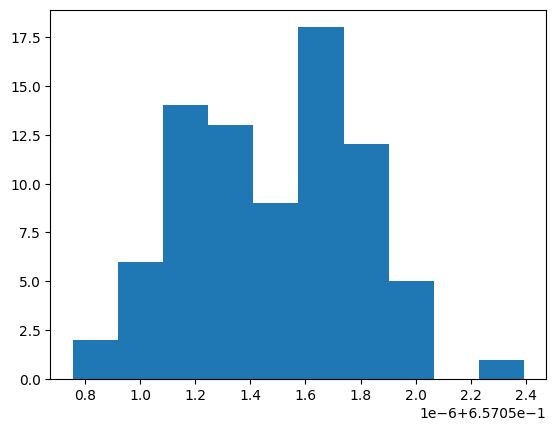

In [9]:
# let's check the distribution of the transformed salaries
plt.hist(bx)

Text(0.5, 1.0, 'LOCAL')

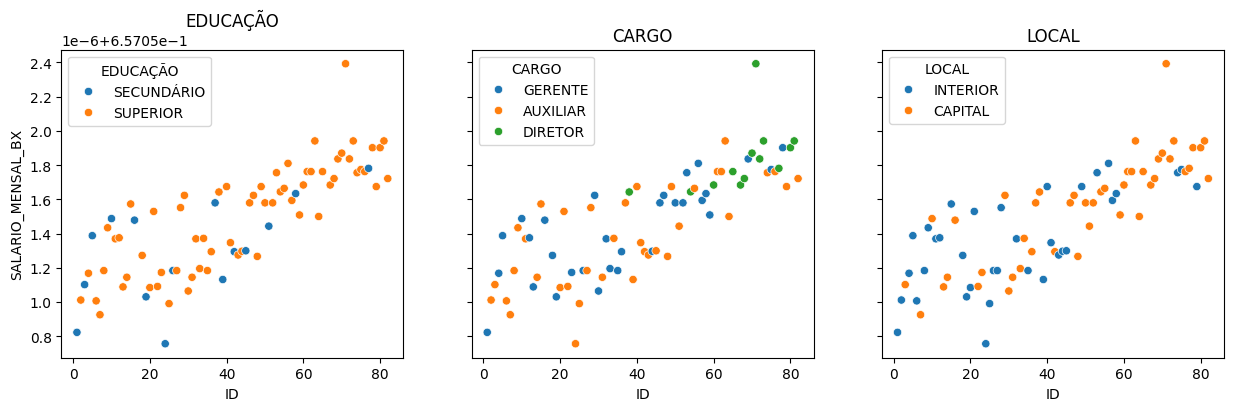

In [10]:
# now let's take a look at how the salary changes according to the categorical variables: level of education, job title and local.

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

sns.scatterplot(df, x = 'ID', y = 'SALARIO_MENSAL_BX',  hue = 'EDUCAÇÃO', ax = axes[0])
axes[0].set_title('EDUCAÇÃO')

sns.scatterplot(df, x = 'ID', y = 'SALARIO_MENSAL_BX',  hue = 'CARGO', ax = axes[1])
axes[1].set_title('CARGO')

sns.scatterplot(df, x = 'ID', y = 'SALARIO_MENSAL_BX',  hue = 'LOCAL', ax = axes[2])
axes[2].set_title('LOCAL')

It is clear that for the job title DIRETOR the salaries tend to be higher (green points). People with this hierarchy also tend to have a higher level of education, but appart from them, the level of education does not seem to have an important effect on salary. For the other job titles GERENTE and AUXILIAR, the difference in salary is not so clear either. And when it comes to location, salaries seem quite mixed as well (no difference between INTERIOR and CAPITAL). To corroborate these observations, I need to take a look at the coefficients of the model.

In [11]:
# drop the columns that are not needed in the model
df1 = df.copy()
df1.drop(['ID', 'SALARIO_MENSAL'], axis=1, inplace=True)

# One-hot encoding of the categorical variables. df_model is the dataframe that will be used to adjust the model
df_model = pd.get_dummies(df1, columns=['EDUCAÇÃO','CARGO', 'LOCAL'], drop_first=True, dtype=int)
df_model.head()

,IDADE,TEMPOCASA,SALARIO_MENSAL_BX,EDUCAÇÃO_SUPERIOR,CARGO_DIRETOR,CARGO_GERENTE,LOCAL_INTERIOR
0,30,1,0.657051,0,0,1,1
1,32,4,0.657051,1,0,0,1
2,33,2,0.657051,0,0,0,0
3,34,3,0.657051,1,0,1,1
4,36,1,0.657051,0,0,1,1


**LINEAR REGRESSION MODEL**

In [12]:
# get features and target
x = df_model.drop('SALARIO_MENSAL_BX', axis=1) # features
y = df_model['SALARIO_MENSAL_BX']              # target
X = sm.add_constant(x)                    # features with intercept

In [13]:
# model with OLS
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      SALARIO_MENSAL_BX   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     44.97
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           1.37e-22
Time:                        15:45:39   Log-Likelihood:                 1147.0
No. Observations:                  80   AIC:                            -2280.
Df Residuals:                      73   BIC:                            -2263.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6571   1.23e-0

The coefficients of the model have confirmed my EDA observations. The coefficients for CARGO_DIRETOR and CARGO_GERENTE are statistically significant (p < 0.05), meaning that the job title or hierarchy determines how much people earn, with directors earning the most. The level of education is not statistically significant when it comes to differences in salary, even with directors having mostly higher education.

**And finally, answering the most important question we had:** Since the coefficient of LOCAL_INTERIOR is not statistically significant (0.212 > 0.05), meaning there are not significant differences between salaries in the CAPITAL and the INTERIOR, **we can conclude that the company is already following the new policy**.